In [38]:
from itertools import product
from functools import lru_cache
import os

from nimare.generate import create_coordinate_dataset
from nimare.meta.ale import ALE
from nimare.meta.mkda import KDA, MKDADensity
from nimare.meta.kernel import KDAKernel, ALEKernel, MKDAKernel
from nimare.correct import FDRCorrector, FWECorrector

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from joblib import Parallel, delayed


In [2]:
@lru_cache(maxsize=None)
def create_dsets(n_dsets, **kwargs):
    return [create_coordinate_dataset(seed=seed, **kwargs)[1] for seed in range(n_dsets)]


In [3]:
N_DSET = 100
NOISE_FOCI = 30
N_JOBS = os.cpu_count()

In [4]:
# create 100 datasets with random coordinates

noise_datasets = create_dsets(N_DSET, foci=0, n_noise_foci=NOISE_FOCI)

In [5]:
# set up the meta analysis estimators
metas = [
    ('ale', ALE),
    ('mkda', MKDADensity),
]

null_methods = [
    {'null_method': 'analytic'},
    {'null_method': 'empirical'},
]

fit_dset_args = list(product(metas, enumerate(noise_datasets), null_methods))

def fit_dset(meta_tuple, dset_tuple, kwargs):
    res = meta_tuple[1](**kwargs).fit(dset_tuple[1])
    p_map = res.get_map("p", return_type="array")
    fpr = (p_map < 0.05).sum() / p_map.shape[0]
    return meta_tuple[0], dset_tuple[0], kwargs['null_method'], fpr, p_map


In [6]:
estimator_results = Parallel(n_jobs=N_JOBS)(delayed(fit_dset)(*args) for args in fit_dset_args)

In [7]:
estimator_collector = {'meta': [], 'dset': [], 'null_method': [], "fpr": [], "p_array": []}
for res in estimator_results:
    estimator_collector['meta'].append(res[0])
    estimator_collector['dset'].append(res[1])
    estimator_collector['null_method'].append(res[2])
    estimator_collector['fpr'].append(res[3])
    estimator_collector['p_array'].append(res[4])

In [8]:
estimator_df = pd.DataFrame(estimator_collector)

In [9]:
ale_analytic = estimator_df.query("meta == 'ale' & null_method == 'analytic'")['p_array'].values
ale_empirical = estimator_df.query("meta == 'ale' & null_method == 'empirical'")['p_array'].values
ale_correlations = np.array([np.corrcoef(analytic, empirical)[0][1] for analytic, empirical in zip(ale_analytic, ale_empirical)])

In [10]:
ale_correlations.mean()

0.9947990879058685

In [11]:
mkda_analytic = estimator_df.query("meta == 'mkda' & null_method == 'analytic'")['p_array'].values
mkda_empirical = estimator_df.query("meta == 'mkda' & null_method == 'empirical'")['p_array'].values
mkda_correlations = np.array([np.corrcoef(analytic, empirical)[0][1] for analytic, empirical in zip(mkda_analytic, mkda_empirical)])

In [12]:
mkda_correlations.mean()

0.9999690974876911

In [13]:
ale_mkda_correlations = np.array([np.corrcoef(ale, mkda)[0][1] for ale, mkda in zip(ale_analytic, mkda_analytic)])

Text(0.5, 1.0, 'False Positive Rates for Meta Analysis Estimators')

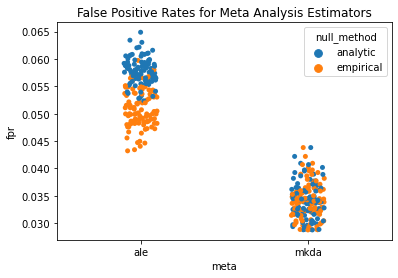

In [14]:
fig = sns.stripplot(data=estimator_df, x='meta', hue='null_method', y='fpr')
fig.set_title("False Positive Rates for Meta Analysis Estimators")

In [23]:
long_df = estimator_df.query("dset == 0").explode('p_array')

Text(0.5, 1.0, 'ALE p-value distributions')

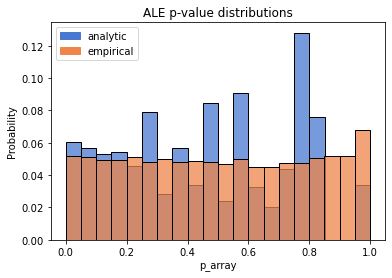

In [47]:
fig, ax = plt.subplots()
sns.histplot(
    data=long_df.query("meta == 'ale' & null_method == 'analytic'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[0],
    stat="probability",
)
sns.histplot(
    data=long_df.query("meta == 'ale' and null_method == 'empirical'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[1],
    stat="probability",
)
ax.legend(
    handles=[
        mpatches.Patch(color=sns.color_palette("muted")[0], label="analytic"),
        mpatches.Patch(color=sns.color_palette("muted")[1], label="empirical"),
    ]
);
ax.set_title("ALE p-value distributions");

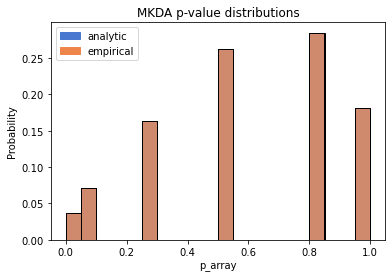

In [48]:
fig, ax = plt.subplots()
sns.histplot(
    data=long_df.query("meta == 'mkda' & null_method == 'analytic'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[0],
    stat="probability",
)
sns.histplot(
    data=long_df.query("meta == 'mkda' and null_method == 'empirical'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[1],
    stat="probability",
)
ax.legend(
    handles=[
        mpatches.Patch(color=sns.color_palette("muted")[0], label="analytic"),
        mpatches.Patch(color=sns.color_palette("muted")[1], label="empirical"),
    ]
);
ax.set_title("MKDA p-value distributions");

Text(0.5, 1.0, 'ALE Empirical/Analytic Correlation')

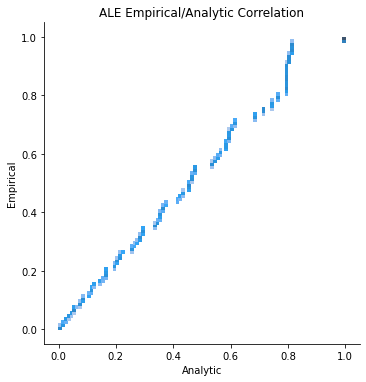

In [54]:
g = sns.displot(
    kind="hist",
    bins=100,
    x=long_df.query("meta == 'ale' & null_method == 'analytic'")['p_array'].values,
    y=long_df.query("meta == 'ale' & null_method == 'empirical'")["p_array"].values,
    rug=False,
)
g.axes[0][0].set_xlabel("Analytic");
g.axes[0][0].set_ylabel("Empirical");
g.axes[0][0].set_title("ALE Empirical/Analytic Correlation")

Text(0.5, 1.0, 'MKDA Empirical/Analytic Correlation')

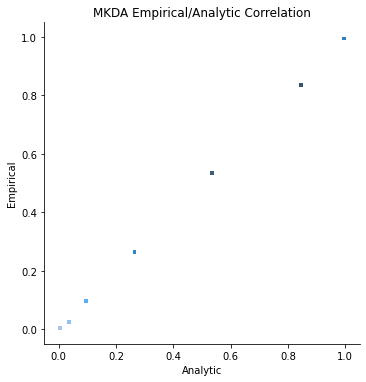

In [55]:
g = sns.displot(
    kind="hist",
    bins=100,
    x=long_df.query("meta == 'mkda' & null_method == 'analytic'")['p_array'].values,
    y=long_df.query("meta == 'mkda' & null_method == 'empirical'")["p_array"].values,
    rug=False,
)
g.axes[0][0].set_xlabel("Analytic");
g.axes[0][0].set_ylabel("Empirical");
g.axes[0][0].set_title("MKDA Empirical/Analytic Correlation")